In [2]:
!pip install tensorflow==2.4.1
!pip install keras==2.4.3

     |████████████████████████████████| 394.3 MB 12 kB/s              
     |████████████████████████████████| 2.9 MB 33.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 462 kB 61.6 MB/s            
     |████████████████████████████████| 3.8 MB 38.2 MB/s            
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77054 sha256=52fe354b5ad52ad38c30a1faebbc758f91727c88b9b5892b22e9bc2862385667
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: grpcio
    Found 

In [3]:
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')

     |████████████████████████████████| 50 kB 4.5 MB/s             
env: SM_FRAMEWORK=tf.keras


2021-12-18 17:48:19.845923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `tf.keras` framework.


In [4]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from segmentation_models import Unet, Linknet, PSPNet, FPN
import keras
from segmentation_models.utils import set_trainable
from torch.utils.data import Dataset

In [5]:
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [6]:
# Path to all data
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 256

In [7]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


dirname                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [8]:
print("Dataframe Size: ", len(df))

Dataframe Size:  7858


In [9]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : x[BASE_LEN:-END_IMG_LEN])
masks = sorted(df_masks["path"].values, key=lambda x : x[BASE_LEN:-END_MASK_LEN])

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_16.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_16_mask.tif


In [10]:
print("length of images: ", len(df_imgs))
print("length of masks: ", len(df_masks))

length of images:  3929
length of masks:  3929


In [11]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

patient  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  diagnosis  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
...                                                 ...        ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  

[3929 rows x 4 columns]

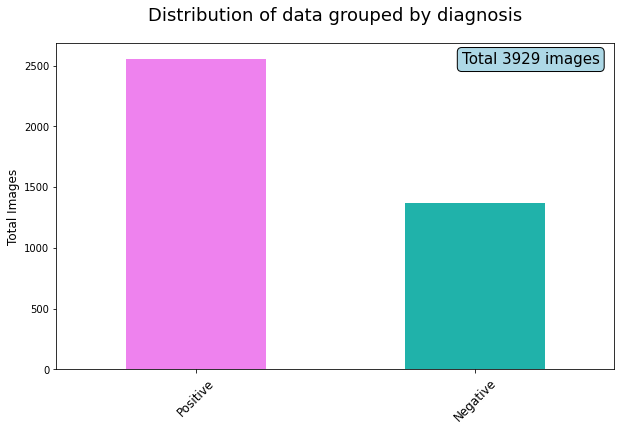

In [12]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

In [13]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = crop_image_from_gray(image)
    #image=cv2.addWeighted(image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

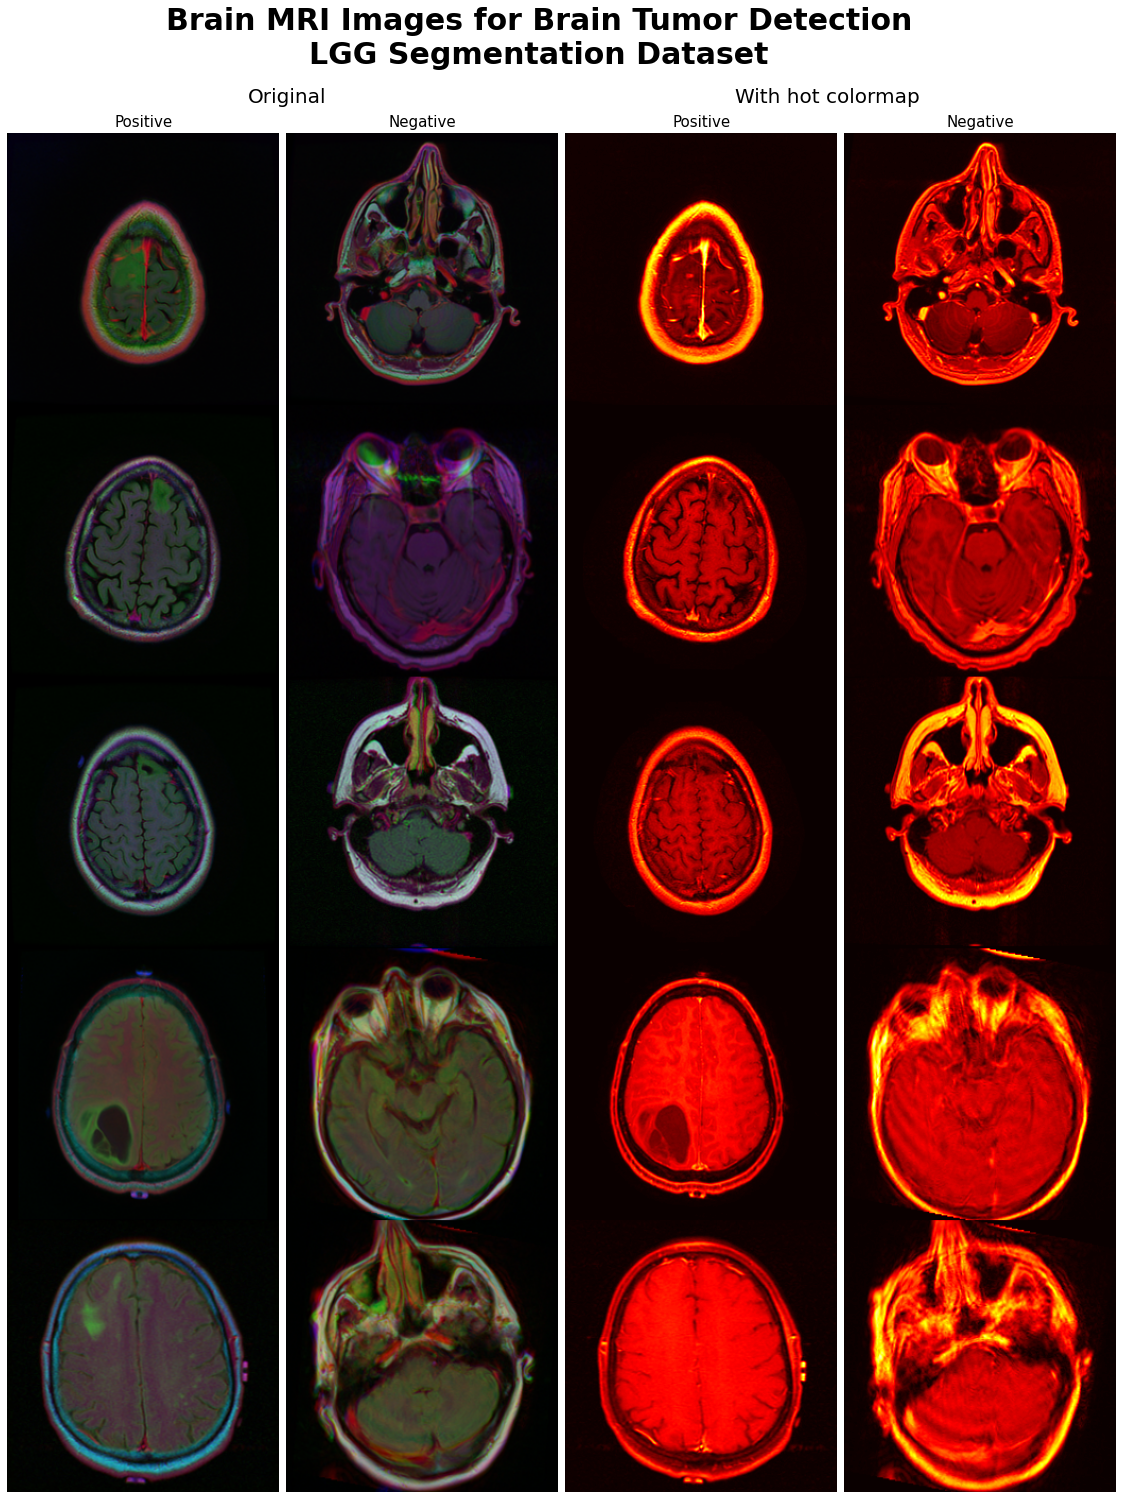

In [14]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

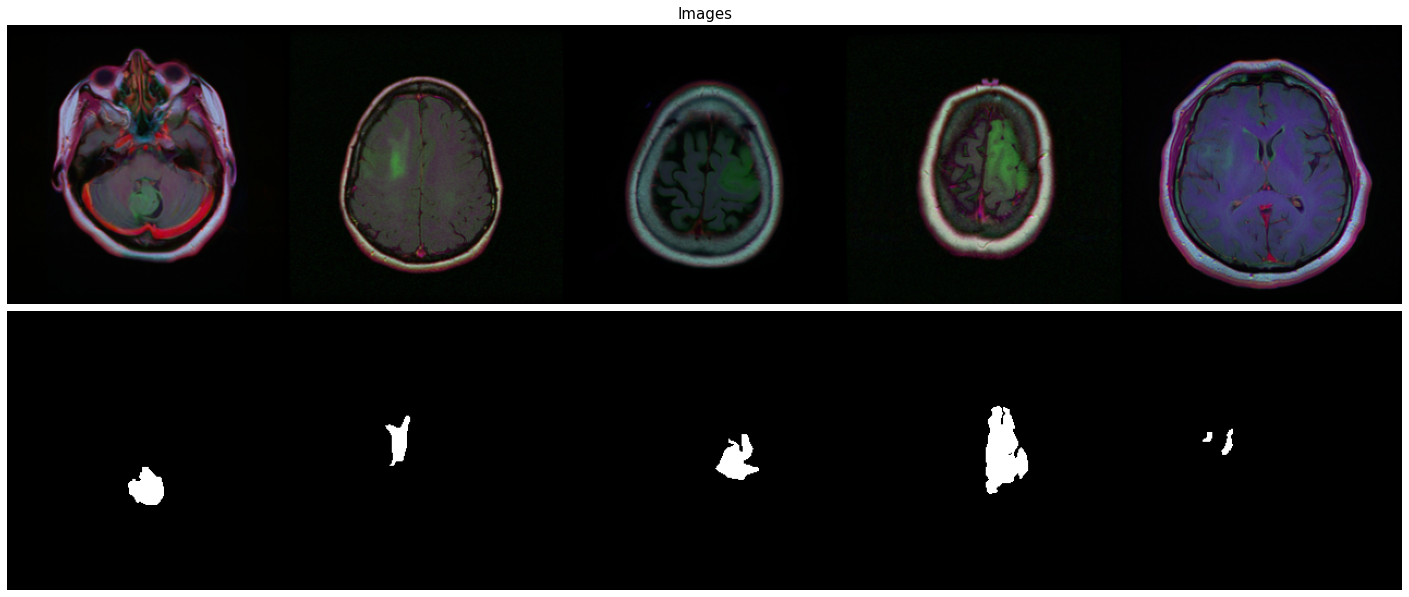

In [15]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

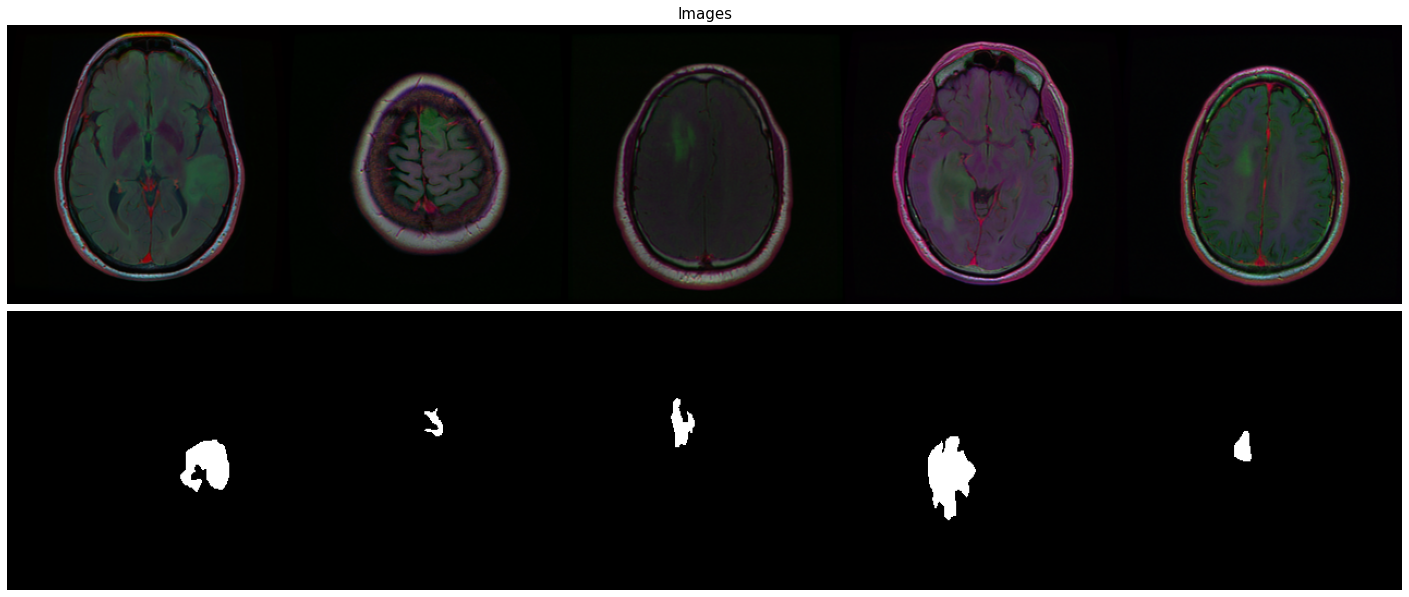

In [16]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = load_ben_color(data[1])
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

In [17]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1, shuffle=True)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [18]:
def normalizing(img):
    norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm

In [19]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensor

In [20]:
PATCH_SIZE = 256

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
    
    
    A.Normalize(p=1.0),
    #https://albumentations.readthedocs.io/en/latest/api/pytorch.html?highlight=ToTensor#albumentations.pytorch.transforms.ToTensor
    ToTensorV2(),
])


transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    
    
    #A.Normalize(p=1.0),
])

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:165: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


In [21]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        # newer version of tf/keras want batch to be in tuple rather than list
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [22]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms, preprocessing=None):
        
        self.df = df
        self.transforms = transforms
        self.preprocessing = preprocessing
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = load_ben_color(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        mask = normalizing(mask)
        
        if self.preprocessing:
            image = self.preprocessing(image)
            
        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']
        
        
        
        return image, mask

In [23]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [24]:
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 # case for binary and multiclass segmentation
activation = 'sigmoid'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True)

# define optomizer
optim = keras.optimizers.Adam(0.001)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
#dice_loss = sm.losses.DiceLoss()
#focal_loss = sm.losses.BinaryFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

2021-12-18 17:48:56.569652: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-18 17:48:56.571010: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-18 17:48:56.606159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 17:48:56.606771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-12-18 17:48:56.606840: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-18 17:48:56.606933: I tensorflow/stream_executor/platform/def

In [25]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms, preprocessing=preprocess_input)
train_dataloader = Dataloder(train_dataset, batch_size=26, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms, preprocessing=preprocess_input)
val_dataloader = Dataloder(val_dataset, batch_size=26, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms, preprocessing=preprocess_input)
test_dataloader = Dataloder(test_dataset, batch_size=26, shuffle=True)

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [27]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=40, 
    validation_data=val_dataloader, 
    validation_steps=len(val_dataloader),
)

2021-12-18 17:49:02.384933: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-18 17:49:02.385772: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000170000 Hz


Epoch 1/40


2021-12-18 17:49:08.151651: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-12-18 17:49:14.002727: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-18 17:49:14.718092: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


115/115 [==============================] - 57s 376ms/step - loss: 0.8991 - iou_score: 0.2362 - f1-score: 0.3612 - val_loss: 1.3894 - val_iou_score: 9.0001e-04 - val_f1-score: 0.0018
Epoch 2/40
115/115 [==============================] - 32s 278ms/step - loss: 0.4923 - iou_score: 0.3834 - f1-score: 0.5446 - val_loss: 0.6594 - val_iou_score: 0.2871 - val_f1-score: 0.4363
Epoch 3/40
115/115 [==============================] - 32s 278ms/step - loss: 0.4372 - iou_score: 0.4241 - f1-score: 0.5850 - val_loss: 0.4229 - val_iou_score: 0.4551 - val_f1-score: 0.6172
Epoch 4/40
115/115 [==============================] - 32s 278ms/step - loss: 0.3810 - iou_score: 0.4795 - f1-score: 0.6395 - val_loss: 0.5123 - val_iou_score: 0.3521 - val_f1-score: 0.5094
Epoch 5/40
115/115 [==============================] - 32s 278ms/step - loss: 0.3487 - iou_score: 0.5109 - f1-score: 0.6701 - val_loss: 0.3402 - val_iou_score: 0.5235 - val_f1-score: 0.6801
Epoch 6/40
115/115 [==============================] - 32s 278m

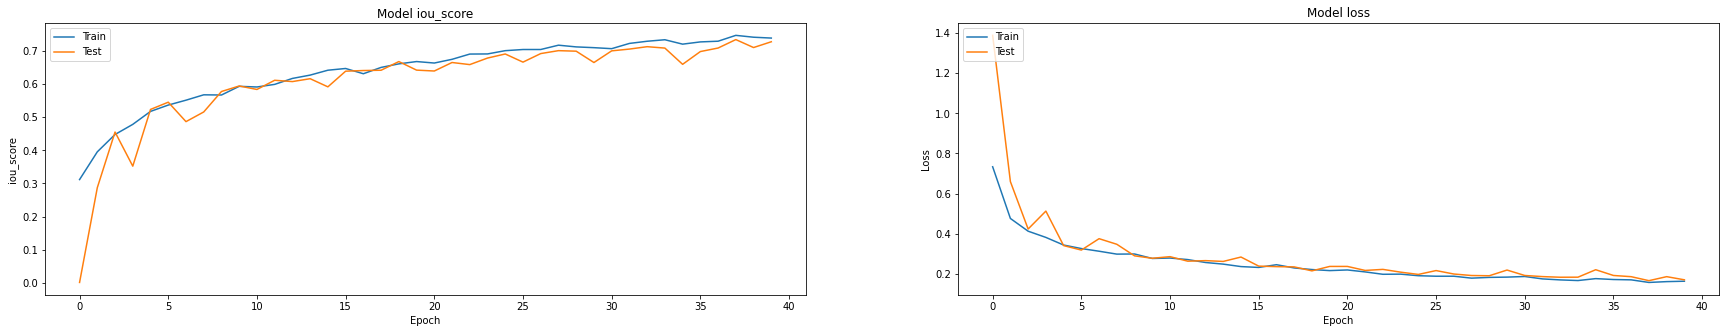

In [28]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

20/20 [==============================] - 6s 332ms/step - loss: 0.2284 - iou_score: 0.6569 - f1-score: 0.7822
Loss: 0.2284
mean iou_score: 0.65692
mean f1-score: 0.78219


In [30]:
model.save_weights("weights-BrainMriSegmentation-UNet+ResNet50.hdf5")

In [31]:
np.save('UNet+ResNet50_history.npy',history.history)

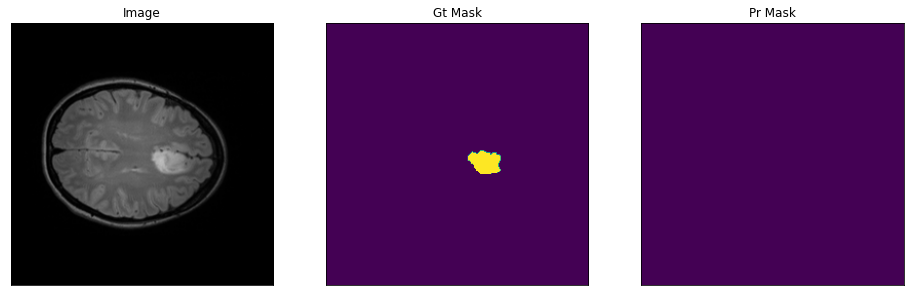

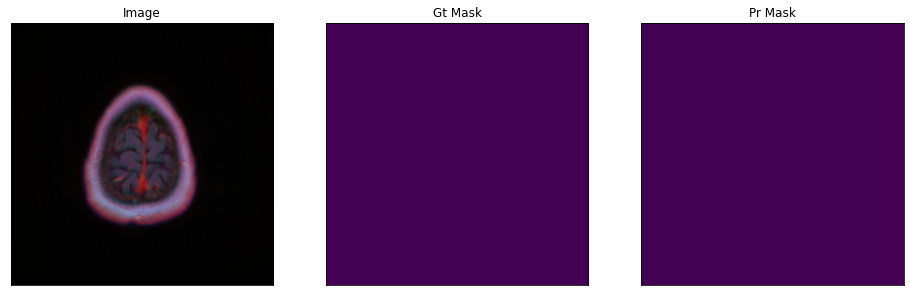

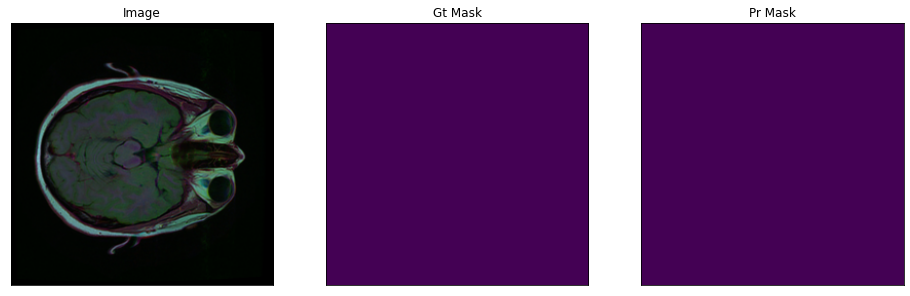

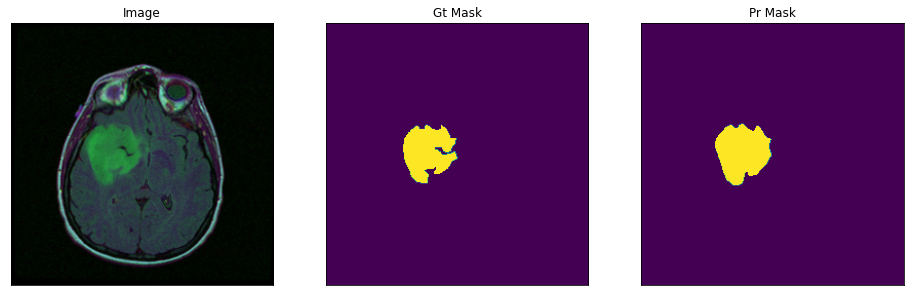

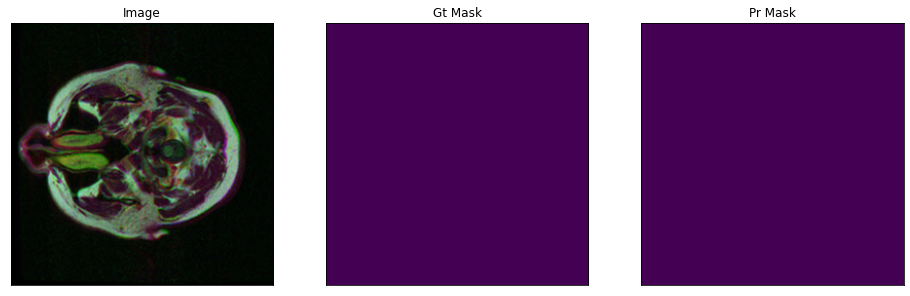

In [32]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=image.squeeze(),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

In [33]:
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 # case for binary and multiclass segmentation
activation = 'sigmoid'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True)

# define optomizer
optim = keras.optimizers.Adam(0.001)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
#dice_loss = sm.losses.DiceLoss()
#focal_loss = sm.losses.BinaryFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [34]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms, preprocessing=preprocess_input)
train_dataloader = Dataloder(train_dataset, batch_size=26, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms, preprocessing=preprocess_input)
val_dataloader = Dataloder(val_dataset, batch_size=26, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms, preprocessing=preprocess_input)
test_dataloader = Dataloder(test_dataset, batch_size=26, shuffle=True)

In [35]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [36]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=40, 
    validation_data=val_dataloader, 
    validation_steps=len(val_dataloader),
)

Epoch 1/40
115/115 [==============================] - 38s 267ms/step - loss: 0.9010 - iou_score: 0.2483 - f1-score: 0.3762 - val_loss: 1.0068 - val_iou_score: 5.7567e-10 - val_f1-score: 5.7567e-10
Epoch 2/40
115/115 [==============================] - 29s 256ms/step - loss: 0.4623 - iou_score: 0.4097 - f1-score: 0.5678 - val_loss: 1.0177 - val_iou_score: 0.0017 - val_f1-score: 0.0034
Epoch 3/40
115/115 [==============================] - 29s 255ms/step - loss: 0.3787 - iou_score: 0.4839 - f1-score: 0.6440 - val_loss: 1.0187 - val_iou_score: 0.0033 - val_f1-score: 0.0064
Epoch 4/40
115/115 [==============================] - 30s 257ms/step - loss: 0.3743 - iou_score: 0.4859 - f1-score: 0.6456 - val_loss: 0.7197 - val_iou_score: 0.1863 - val_f1-score: 0.3042
Epoch 5/40
115/115 [==============================] - 30s 259ms/step - loss: 0.3340 - iou_score: 0.5281 - f1-score: 0.6834 - val_loss: 0.4594 - val_iou_score: 0.4048 - val_f1-score: 0.5576
Epoch 6/40
115/115 [===========================

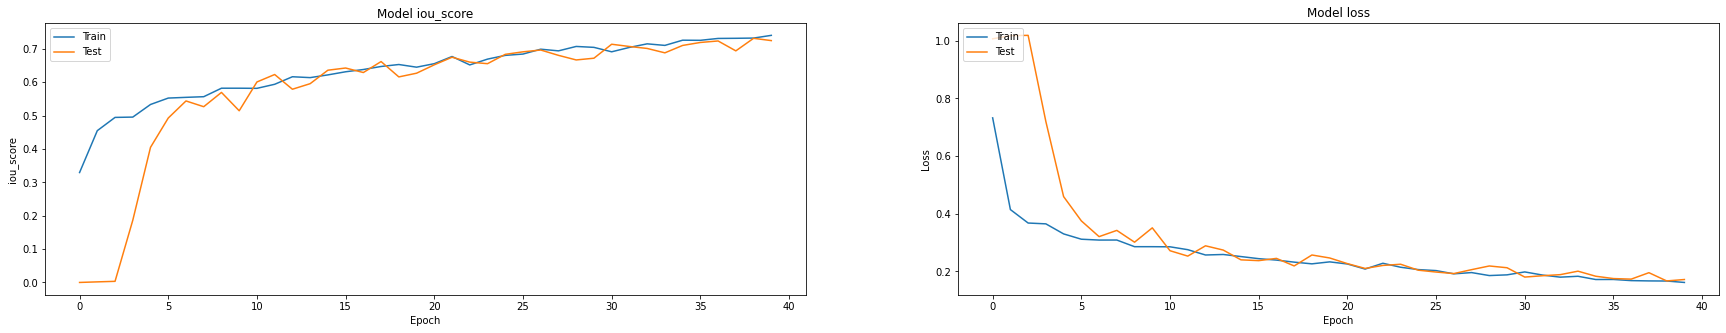

In [37]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [38]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

20/20 [==============================] - 3s 141ms/step - loss: 0.2115 - iou_score: 0.6773 - f1-score: 0.7987
Loss: 0.21146
mean iou_score: 0.67735
mean f1-score: 0.79866


In [39]:
model.save_weights("weights-BrainMriSegmentation-UNet+InceptionV3.hdf5")

In [40]:
np.save('UNet+InceptionV3_history.npy',history.history)

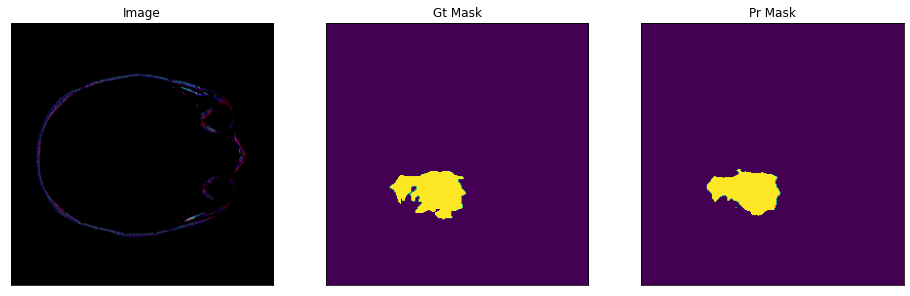

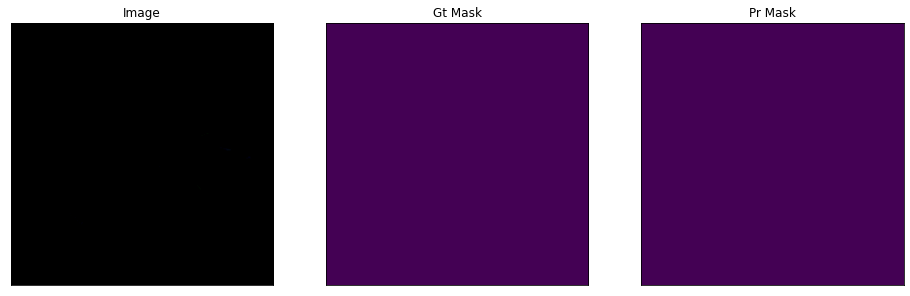

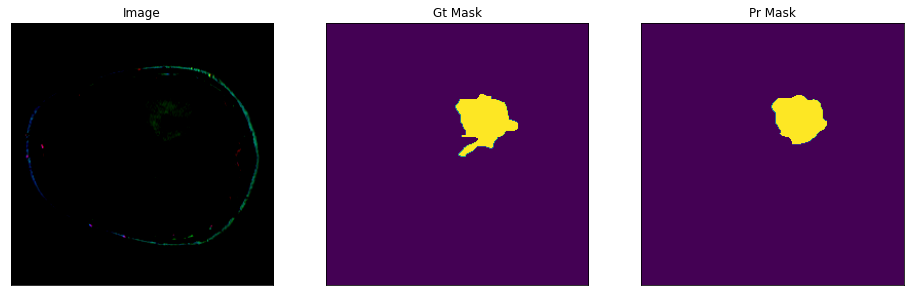

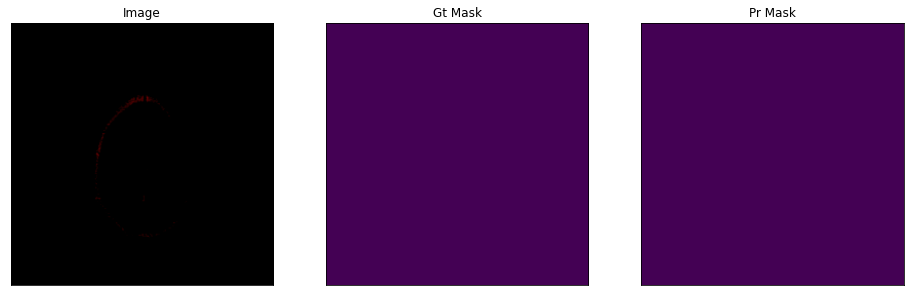

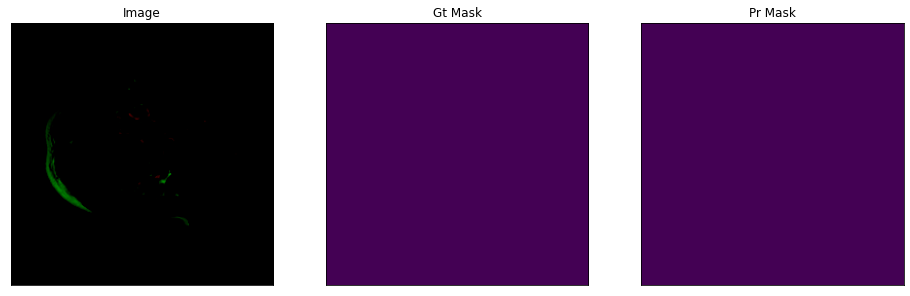

In [41]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=image.squeeze(),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )